# Ensemble Model

In [5]:
from collections import Counter
import json

In [30]:
import sys
import numpy as np

from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

sys.path.append("/Users/bobaebak/git/ai_text_detection")
from utils.plot_helper import *

In [3]:
classifiers_predictions = {
    "openai": None,
    "openai_finetuned": None,
    "radar": None,
    "GPTZero": None,
    "DetectGPT": None
}

# Dominant Answers

In [7]:
def final_prediction(classifiers_predictions):
    # Count occurrences of each sentiment prediction
    sentiment_counts = Counter(classifiers_predictions)
    # Choose the sentiment with the highest count
    final_sentiment = max(sentiment_counts, key=sentiment_counts.get)
    return final_sentiment

In [10]:
with open('../dataset/eval/h_openai_eval.json', "r") as f:
    eval_openai_detector = json.load(f)
    for item in eval_openai_detector:
        item['rlabel'] = 'Real'
with open('../dataset/eval/m_openai_eval.json', "r") as f:
    eval_openai_detector.extend(json.load(f))
    for item in eval_openai_detector:
        if "rlabel" not in item:
            item['rlabel'] = 'Fake'

with open('../dataset/eval/h_openai_finetuned_eval.json', "r") as f:
    eval_openai_finetuned_detector = json.load(f)
    for item in eval_openai_finetuned_detector:
        item['rlabel'] = 'Real'
with open('../dataset/eval/m_openai_finetuned_eval.json', "r") as f:
    eval_openai_finetuned_detector.extend(json.load(f))
    for item in eval_openai_finetuned_detector:
        if "rlabel" not in item:
            item['rlabel'] = 'Fake'

with open('../dataset/eval/h_radar_eval.json', "r") as f:
    eval_radar = json.load(f)
    for item in eval_radar:
        item['rlabel'] = 'Real'
with open('../dataset/eval/m_radar_eval.json', "r") as f:
    eval_radar.extend(json.load(f))
    for item in eval_radar:
        if "rlabel" not in item:
            item['rlabel'] = 'Fake'        

with open('../dataset/eval/h_gptzero_eval.json', "r") as f:
    eval_gptzero = json.load(f)
    for item in eval_gptzero:
        item['rlabel'] = 'Real'
with open('../dataset/eval/m_gptzero_eval.json', "r") as f:
    eval_gptzero.extend(json.load(f))
    for item in eval_gptzero:
        if "rlabel" not in item:
            item['rlabel'] = 'Fake'        

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Ensemble & 0.80 & 0.73 & 0.94 & 0.82 & 0.66 & 0.80


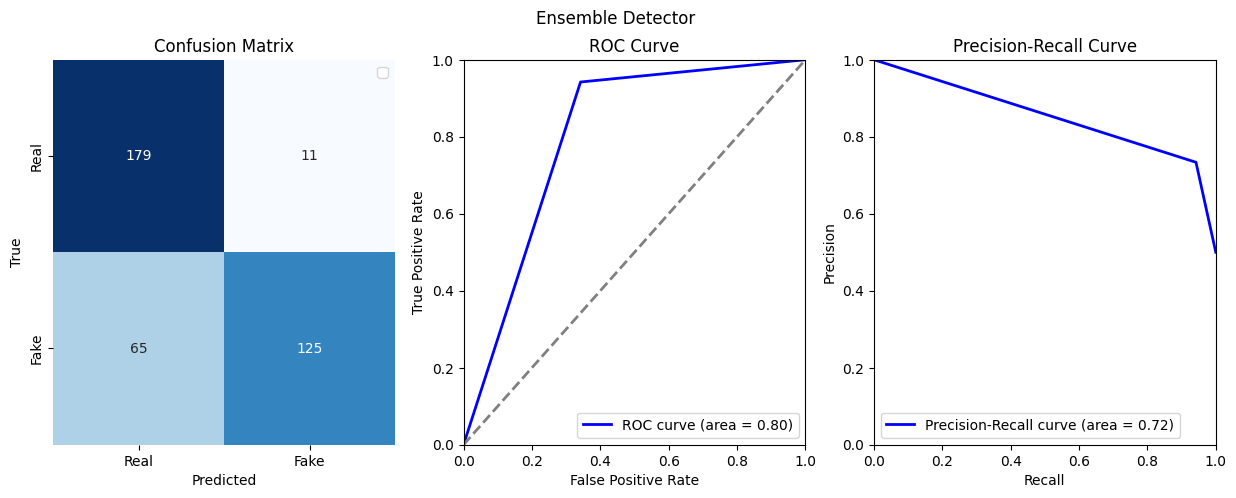

In [32]:
# Example usage

true_labels = []
predicted_labels = []
for e1, e2, e3, e4 in zip(eval_openai_detector, eval_openai_finetuned_detector, eval_radar, eval_gptzero):
    #### e1
    if float(e1['Real']) > float(e1['Fake']):
        e1_pred = "Real"
    else:
        e1_pred = "Fake"

    #### e2
    if float(e2['Real']) > float(e2['Fake']):
        e2_pred = "Real"
    else:
        e2_pred = "Fake"     

    #### e3
    if float(e3['Real']) > float(e3['Fake']):
        e3_pred = "Real"
    else:
        e3_pred = "Fake"     

    #### e4
    if e4['label'] == 1:
        e4_pred = 'Real'
    else:
        e4_pred = 'Fake'
    
    if e1['rlabel'] == e2['rlabel'] == e3['rlabel'] == e4['rlabel']:
        true_labels.append(e1['rlabel'])
        classifiers_predictions = [e1_pred, e2_pred, e3_pred, e4_pred]  
        predicted_labels.append(final_prediction(classifiers_predictions))
    # else:
    #     print(e4)

    
# calculate Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Real', 'Fake'])

# calculate ROC Curve
true_binary = [1 if label == 'Real' else 0 for label in true_labels]
predicted_binary = [1 if label == 'Real' else 0 for label in predicted_labels]
fpr, tpr, thresholds = roc_curve(true_binary, predicted_binary)
roc_auc = auc(fpr, tpr)

# calculate Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(true_binary, predicted_binary)
average_precision = average_precision_score(true_binary, predicted_binary)

#### Plot both confusion matrices side by side
helper = PlotHelper(
    col=3, figsize=(15, 5), title="Ensemble Detector",
    plots=[
        PlotItem(
            ptype="heatmap", xlabel='Predicted', ylabel='True', title='Confusion Matrix',
            x=[conf_matrix],
            args=[{"annot": True, "fmt":'d', "cbar":False, "cmap":'Blues', "xticklabels":['Real', 'Fake'], "yticklabels":['Real', 'Fake']}],
        ),
        PlotItem(
            ptype="plot", xlabel="False Positive Rate", ylabel="True Positive Rate", title="ROC Curve",
            xlim=(0.0, 1.0), ylim=(0.0, 1.0),
            x=[fpr, [0,1]],
            y=[tpr, [0,1]],
            args=[{"color":"blue", "lw":2, "label":'ROC curve (area = %0.2f)' % roc_auc}, {"color": "grey", "lw":2, "linestyle": "--"}]
        ),
        PlotItem(
            ptype="plot", xlabel="Recall", ylabel="Precision", title="Precision-Recall Curve",
            xlim=(0.0, 1.0), ylim=(0.0, 1.0),
            x=[recall, [1,1]],
            y=[precision, [1,1]],
            args=[{"color":"blue", "lw":2, "label":'Precision-Recall curve (area = %0.2f)' % average_precision}, {"color": "grey", "lw":2, "linestyle": "--"}]
        ),
    ]
)

draws(helper)

# Sum the diagonal elements (true positives + true negatives)
correct_predictions = np.trace(conf_matrix)

# Sum all elements in the confusion matrix
total_predictions = np.sum(conf_matrix)

# Methods & Accuracy & Precision & Recall & F1 & Specificity & AUC
accuracy = accuracy_score(true_binary, predicted_binary)
precision = precision_score(true_binary, predicted_binary)
recall = recall_score(true_binary, predicted_binary)
f1 = f1_score(true_binary, predicted_binary)
tn, fp, fn, tp = confusion_matrix(true_binary, predicted_binary).ravel()
specificity = tn / (tn + fp)
auc_score = roc_auc

print(f"Ensemble & {accuracy:.2f} & {precision:.2f} & {recall:.2f} & {f1:.2f} & {specificity:.2f} & {roc_auc:.2f}")

# Weighted Answers

In [39]:
def final_prediction_weighted(classifiers_predictions, weights):
    weighted_sum = {sentiment: 0 for sentiment in set(classifiers_predictions)}
    print(weighted_sum)
    for prediction, weight in zip(classifiers_predictions, weights):
        weighted_sum[prediction] += weight
    print(weighted_sum)        
    final_sentiment = max(weighted_sum, key=weighted_sum.get)
    print(final_sentiment)
    return final_sentiment

# Example usage
classifiers_predictions = ['positive', 'negative', 'neutral', 'positive', 'neutral']
weights = [0.8, 0.6, 0.7, 0.9, 0.5]  # Example weights
final_prediction_weighted(classifiers_predictions, weights)

{'positive': 0, 'neutral': 0, 'negative': 0}
{'positive': 1.7000000000000002, 'neutral': 1.2, 'negative': 0.6}
positive


'positive'

In [ ]:
weighted_sum = {sentiment: 0 for sentiment in set(classifiers_predictions)}
for prediction, weight in zip(classifiers_predictions, weights):
    weighted_sum[prediction] += weight
final_sentiment = max(weighted_sum, key=weighted_sum.get)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Ensemble & 0.94 & 0.92 & 0.96 & 0.94 & 0.92 & 0.94


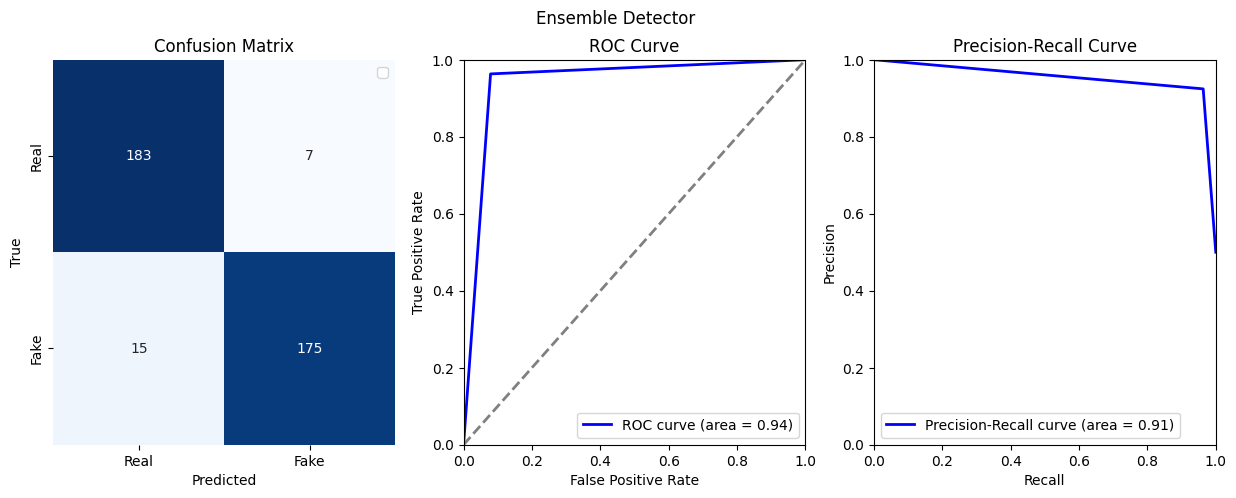

In [34]:
# Example usage

# weights are the accuracy
weights = [0.53, 0.94, 0.51, 0.74]

true_labels = []
predicted_labels = []
for e1, e2, e3, e4 in zip(eval_openai_detector, eval_openai_finetuned_detector, eval_radar, eval_gptzero):
    #### e1
    if float(e1['Real']) > float(e1['Fake']):
        e1_pred = "Real"
    else:
        e1_pred = "Fake"

    #### e2
    if float(e2['Real']) > float(e2['Fake']):
        e2_pred = "Real"
    else:
        e2_pred = "Fake"     

    #### e3
    if float(e3['Real']) > float(e3['Fake']):
        e3_pred = "Real"
    else:
        e3_pred = "Fake"     

    #### e4
    if e4['label'] == 1:
        e4_pred = 'Real'
    else:
        e4_pred = 'Fake'
    
    if e1['rlabel'] == e2['rlabel'] == e3['rlabel'] == e4['rlabel']:
        true_labels.append(e1['rlabel'])
        classifiers_predictions = [e1_pred, e2_pred, e3_pred, e4_pred]  
        
        predicted_labels.append(final_prediction_weighted(classifiers_predictions, weights))
    # else:
    #     print(e4)

    
# calculate Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Real', 'Fake'])

# calculate ROC Curve
true_binary = [1 if label == 'Real' else 0 for label in true_labels]
predicted_binary = [1 if label == 'Real' else 0 for label in predicted_labels]
fpr, tpr, thresholds = roc_curve(true_binary, predicted_binary)
roc_auc = auc(fpr, tpr)

# calculate Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(true_binary, predicted_binary)
average_precision = average_precision_score(true_binary, predicted_binary)

#### Plot both confusion matrices side by side
helper = PlotHelper(
    col=3, figsize=(15, 5), title="Ensemble Detector",
    plots=[
        PlotItem(
            ptype="heatmap", xlabel='Predicted', ylabel='True', title='Confusion Matrix',
            x=[conf_matrix],
            args=[{"annot": True, "fmt":'d', "cbar":False, "cmap":'Blues', "xticklabels":['Real', 'Fake'], "yticklabels":['Real', 'Fake']}],
        ),
        PlotItem(
            ptype="plot", xlabel="False Positive Rate", ylabel="True Positive Rate", title="ROC Curve",
            xlim=(0.0, 1.0), ylim=(0.0, 1.0),
            x=[fpr, [0,1]],
            y=[tpr, [0,1]],
            args=[{"color":"blue", "lw":2, "label":'ROC curve (area = %0.2f)' % roc_auc}, {"color": "grey", "lw":2, "linestyle": "--"}]
        ),
        PlotItem(
            ptype="plot", xlabel="Recall", ylabel="Precision", title="Precision-Recall Curve",
            xlim=(0.0, 1.0), ylim=(0.0, 1.0),
            x=[recall, [1,1]],
            y=[precision, [1,1]],
            args=[{"color":"blue", "lw":2, "label":'Precision-Recall curve (area = %0.2f)' % average_precision}, {"color": "grey", "lw":2, "linestyle": "--"}]
        ),
    ]
)

draws(helper)

# Sum the diagonal elements (true positives + true negatives)
correct_predictions = np.trace(conf_matrix)

# Sum all elements in the confusion matrix
total_predictions = np.sum(conf_matrix)

# Methods & Accuracy & Precision & Recall & F1 & Specificity & AUC
accuracy = accuracy_score(true_binary, predicted_binary)
precision = precision_score(true_binary, predicted_binary)
recall = recall_score(true_binary, predicted_binary)
f1 = f1_score(true_binary, predicted_binary)
tn, fp, fn, tp = confusion_matrix(true_binary, predicted_binary).ravel()
specificity = tn / (tn + fp)
auc_score = roc_auc

print(f"Ensemble & {accuracy:.2f} & {precision:.2f} & {recall:.2f} & {f1:.2f} & {specificity:.2f} & {roc_auc:.2f}")